## Modelos ET

Mediante este script se pretende observar y arrojar conclusoones sobre la viariabilidad y correlaciones de los datos en función de los distintos ruidos en la simulación de datos.

Entrenaremos y evaluaremos models Extra Trees, un tipo de Árboles de decisión con un extra de Aleatorización, veremos como funciona entrenando los modelos con los datos establecidos y extraeremos cual tiene mayor capacidad predictora y explicativa mediante la importancia que toman las variables en el arbol de decisión.

Si bien no establece principio de causalidad, es un buen modelo para obtener las variables que más influyen estadísticamente a la casificación de la Edad de Menarquia.


### Carga y Diccionario de Datos

In [1]:
# PyCaret para regresión
from pycaret.regression import setup, create_model, tune_model, finalize_model, predict_model, pull

# Modelos de regresión (scikit-learn y otros)
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from imodels import RuleFitRegressor

# Herramientas de evaluación y visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Manipulación de datos
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
# Lista para guardar los DataFrames
dataframes_sin_log = []

# Leer los archivos Excel del 1 al 5
for i in range(1, 6):
    filename = f'Pregnancy_{i}.xlsx'
    try:
        df = pd.read_excel(filename)
        dataframes_sin_log.append(df)
        print(f"Archivo leído correctamente: {filename}")
    except FileNotFoundError:
        print(f"Archivo no encontrado: {filename}")
    except Exception as e:
        print(f"Error al leer {filename}: {e}")


for i, df in enumerate(dataframes_sin_log):
    if 'PCBtotal3' in df.columns:
        df.rename(columns={'PCBtotal3': 'PCB'}, inplace=True)
        print(f"Renombrada columna en DataFrame {i+1}")
    else:
        print(f"'PCBtotal3' no se encontró en DataFrame {i+1}")

dataframes_sin_log_sin_id = [df.drop(columns=['idnum'], errors='ignore') for df in dataframes_sin_log]



Archivo leído correctamente: Pregnancy_1.xlsx
Archivo leído correctamente: Pregnancy_2.xlsx
Archivo leído correctamente: Pregnancy_3.xlsx
Archivo leído correctamente: Pregnancy_4.xlsx
Archivo leído correctamente: Pregnancy_5.xlsx
Renombrada columna en DataFrame 1
Renombrada columna en DataFrame 2
Renombrada columna en DataFrame 3
Renombrada columna en DataFrame 4
Renombrada columna en DataFrame 5


In [3]:
# Lista con las columnas a transformar
columnas_log = ['pfhxs', 'pfoa', 'pfos', 'pfna', 'v_44DDT', 'v_44DDE', 'HCB', 'bHCH', 'PCB']

# Crear la nueva lista con copias profundas
dataframes_con_log = []

for i, df in enumerate(dataframes_sin_log):
    # Hacer una copia del DataFrame original
    df_log = df.copy()
    
    # Aplicar transformación logarítmica solo si la columna existe y es numérica
    for col in columnas_log:
        if col in df_log.columns:
            # Para evitar log(0) o valores negativos, se añade una pequeña constante si es necesario
            df_log[col] = np.log(df_log[col].replace(0, np.nan))
    
    dataframes_con_log.append(df_log)
    print(f"Transformación log aplicada al DataFrame {i+1}")


Transformación log aplicada al DataFrame 1
Transformación log aplicada al DataFrame 2
Transformación log aplicada al DataFrame 3
Transformación log aplicada al DataFrame 4
Transformación log aplicada al DataFrame 5


In [4]:
def entrenar_modelos(lista_dfs,
                             nombre_lista,
                             target_variable,
                             model_name,
                             params_modelo,
                             test_size=0.2,
                             random_state=123):
    """
    Entrena modelos usando scikit-learn, con codificación automática de categóricas.
    Retorna lista de tuplas (modelo, X_train, y_train).
    """
    resultados = []
    for i, df in enumerate(lista_dfs, start=1):
        print(f"\n------ Procesando DataFrame {i}/{len(lista_dfs)} ({nombre_lista}) ------")
        df_clean = df.dropna(subset=[target_variable]).copy()

        # Separar X e y
        X = df_clean.drop(columns=[target_variable])
        y = df_clean[target_variable]

        # Codificar categóricas
        cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
        if cat_cols:
            X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

        # Split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            test_size=test_size,
            random_state=random_state
        )

        # Instanciar modelo
        if model_name == 'xgboost':
            modelo = XGBRegressor(**params_modelo)
        elif model_name == 'lightgbm':
            modelo = LGBMRegressor(**params_modelo)
        elif model_name == 'rf':
            modelo = RandomForestRegressor(**params_modelo)
        elif model_name == 'et':
            valid_crit = {'squared_error', 'absolute_error', 'friedman_mse', 'poisson'}
            crit = params_modelo.get('criterion', 'squared_error')
            if crit not in valid_crit:
                raise ValueError(f"Criterion inválido para ExtraTrees: {crit}. Debe ser uno de {valid_crit}")
            modelo = ExtraTreesRegressor(**params_modelo)
        else:
            raise ValueError(f"Modelo no reconocido: {model_name}")

        modelo.fit(X_train, y_train)
        resultados.append((modelo, X_train, y_train))

    return resultados

In [5]:
def generar_rulefits(modelos, nombre_lista):
    """
    A partir de una lista de tuplas (modelo, X_train, y_train),
    entrena un RuleFitRegressor para cada modelo base aplicable.
    Devuelve lista de tuplas (rulefit_modelo, X_train, y_train).
    """
    resultados = []
    for i, (modelo_base, X_train, y_train) in enumerate(modelos, start=1):
        # Aplicar RuleFit solo si X_train/y_train están disponibles
        if X_train is None or y_train is None:
            continue
        # Entrena RuleFit
        print(f"Entrenando RuleFit para {nombre_lista}_{i}...")
        rf_reg = RuleFitRegressor()
        rf_reg.fit(X_train, y_train)
        resultados.append((rf_reg, X_train, y_train))
    return resultados

### Extra Trees Classifier

In [6]:
%%capture
params_et = {
    'n_estimators': 200,
    'criterion': 'squared_error',
    'max_depth': 10,
    'max_features': 'sqrt',
    'min_samples_split': 5,
    'min_samples_leaf': 2,
    'bootstrap': False,
    'random_state': 123,
    'n_jobs': -1
}

target_variable = 'edad_menarquia'

modelos_sin_log = entrenar_modelos(
    lista_dfs=dataframes_sin_log,
    nombre_lista="sin log",
    target_variable=target_variable,
    model_name='et',
    params_modelo=params_et
)

modelos_con_log = entrenar_modelos(
    lista_dfs=dataframes_con_log,
    nombre_lista="con log",
    target_variable=target_variable,
    model_name='et',
    params_modelo=params_et
)


### Lightgbm

In [7]:
%%capture
params_lgbm = {
    'n_estimators': 200,
    'learning_rate': 0.05,
    'max_depth': 10,
    'num_leaves': 31,
    'min_child_samples': 20,
    'random_state': 123,
    'n_jobs': -1
}

modelos_lgbm_sin_log = entrenar_modelos(
    lista_dfs=dataframes_sin_log,
    nombre_lista="sin log",
    target_variable=target_variable,
    model_name='lightgbm',
    params_modelo=params_lgbm
)

modelos_lgbm_con_log = entrenar_modelos(
    lista_dfs=dataframes_con_log,
    nombre_lista="con log",
    target_variable=target_variable,
    model_name='lightgbm',
    params_modelo=params_lgbm
)


### XGBoost

In [8]:
%%capture
params_xgb = {
    'n_estimators': 200,
    'learning_rate': 0.05,
    'max_depth': 10,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 123,
    'n_jobs': -1
}

modelos_xgb_sin_log = entrenar_modelos(
    lista_dfs=dataframes_sin_log,
    nombre_lista="sin log",
    target_variable=target_variable,
    model_name='xgboost',
    params_modelo=params_xgb
)

modelos_xgb_con_log = entrenar_modelos(
    lista_dfs=dataframes_con_log,
    nombre_lista="con log",
    target_variable=target_variable,
    model_name='xgboost',
    params_modelo=params_xgb
)


### Random Forest

In [9]:
%%capture
params_rf = {
    'n_estimators': 200,
    'max_depth': 10,
    'min_samples_split': 5,
    'min_samples_leaf': 2,
    'max_features': 'sqrt',
    'bootstrap': True,
    'random_state': 123,
    'n_jobs': -1
}

modelos_rf_sin_log = entrenar_modelos(
    lista_dfs=dataframes_sin_log,
    nombre_lista="sin log",
    target_variable=target_variable,
    model_name='rf',
    params_modelo=params_rf
)

modelos_rf_con_log = entrenar_modelos(
    lista_dfs=dataframes_con_log,
    nombre_lista="con log",
    target_variable=target_variable,
    model_name='rf',
    params_modelo=params_rf
)


In [10]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [11]:
def evaluar_modelos(modelos, nombre_lista):
    """
    Evalúa una lista de modelos entrenados.
    Cada elemento en `modelos` es una tupla (modelo, X_train, y_train).
    Devuelve un DataFrame con métrica R2, RMSE y MAE.
    """
    registros = []
    for i, (modelo, X, y) in enumerate(modelos, start=1):
        print(f"\n📊 Evaluando {nombre_lista} modelo {i}...")
        # Predicciones sobre datos de entrenamiento
        y_pred = modelo.predict(X)
        # Cálculo de métricas
        r2 = r2_score(y, y_pred)
        rmse = mean_squared_error(y, y_pred, squared=False)
        mae = mean_absolute_error(y, y_pred)
        registros.append({
            'modelo': f"{nombre_lista}_{i}",
            'r2': r2,
            'rmse': rmse,
            'mae': mae
        })
    return pd.DataFrame(registros)

In [12]:
rulefits_rf_sin_log=generar_rulefits(modelos_rf_sin_log,"rf_sin_log")
rulefits_rf_con_log=generar_rulefits(modelos_rf_con_log,"rf_con_log")

Entrenando RuleFit para rf_sin_log_1...
Entrenando RuleFit para rf_sin_log_2...
Entrenando RuleFit para rf_sin_log_3...
Entrenando RuleFit para rf_sin_log_4...
Entrenando RuleFit para rf_sin_log_5...
Entrenando RuleFit para rf_con_log_1...
Entrenando RuleFit para rf_con_log_2...
Entrenando RuleFit para rf_con_log_3...
Entrenando RuleFit para rf_con_log_4...
Entrenando RuleFit para rf_con_log_5...


In [21]:
%%capture
resumen_sin_log = evaluar_modelos(modelos_sin_log, "sin_log")
resumen_con_log = evaluar_modelos(modelos_con_log, "con_log")

resumen_lightgbm_sin_log = evaluar_modelos(modelos_lgbm_sin_log, "sin_log")
resumen_lightgbm_con_log = evaluar_modelos(modelos_lgbm_con_log, "con_log")

resumen_xgb_sin_log = evaluar_modelos(modelos_xgb_sin_log, "sin_log")
resumen_xgb_con_log = evaluar_modelos(modelos_xgb_con_log, "con_log")

resumen_rf_sin_log = evaluar_modelos(modelos_rf_sin_log, "sin_log")
resumen_rf_con_log = evaluar_modelos(modelos_rf_con_log, "con_log")

resumen_rulefits_rf_sin_log = evaluar_modelos(rulefits_rf_sin_log, "rf_rf_sin_log")
resumen_rulefits_rf_con_log = evaluar_modelos(rulefits_rf_con_log, "rf_rf_con_log")


In [14]:

# Opcional: ver todo junto
resumen_total_et = pd.concat([resumen_sin_log, resumen_con_log], ignore_index=True)

# Mostrar resultados agrupados por modelo
print(resumen_total_et)

      modelo        r2      rmse       mae
0  sin_log_1  0.528202  0.860087  0.665123
1  sin_log_2  0.580115  0.811390  0.618481
2  sin_log_3  0.615102  0.776850  0.590120
3  sin_log_4  0.642748  0.748432  0.565000
4  sin_log_5  0.675202  0.713626  0.535897
5  con_log_1  0.519309  0.868155  0.672061
6  con_log_2  0.574201  0.817084  0.630169
7  con_log_3  0.607813  0.784172  0.602145
8  con_log_4  0.640586  0.750692  0.572112
9  con_log_5  0.665187  0.724545  0.553890


In [15]:
resumen_total_lightgbm = pd.concat([resumen_lightgbm_sin_log, resumen_lightgbm_con_log], ignore_index=True)
print(resumen_total_lightgbm)

      modelo        r2      rmse       mae
0  sin_log_1  0.943315  0.298124  0.223248
1  sin_log_2  0.964558  0.235735  0.171999
2  sin_log_3  0.977103  0.189474  0.141191
3  sin_log_4  0.976686  0.191193  0.132960
4  sin_log_5  0.984995  0.153387  0.106070
5  con_log_1  0.944644  0.294609  0.219741
6  con_log_2  0.967056  0.227276  0.167951
7  con_log_3  0.976743  0.190958  0.143229
8  con_log_4  0.978655  0.182943  0.127682
9  con_log_5  0.983330  0.161671  0.111621


In [16]:
resumen_total_xgb = pd.concat([resumen_xgb_sin_log, resumen_xgb_con_log], ignore_index=True)
print(resumen_total_xgb)

      modelo        r2      rmse       mae
0  sin_log_1  0.999574  0.025850  0.017034
1  sin_log_2  0.999819  0.016851  0.010726
2  sin_log_3  0.999904  0.012293  0.007827
3  sin_log_4  0.999855  0.015054  0.009613
4  sin_log_5  0.999886  0.013378  0.007982
5  con_log_1  0.999574  0.025850  0.017034
6  con_log_2  0.999819  0.016851  0.010726
7  con_log_3  0.999904  0.012293  0.007827
8  con_log_4  0.999855  0.015054  0.009613
9  con_log_5  0.999886  0.013378  0.007982


In [17]:
resumen_total_rf_rf = pd.concat([resumen_rulefits_rf_sin_log, resumen_rulefits_rf_con_log], ignore_index=True)
print(resumen_total_rf_rf)

            modelo        r2      rmse       mae
0  rf_rf_sin_log_1  0.234707  1.095414  0.869100
1  rf_rf_sin_log_2  0.300102  1.047567  0.829254
2  rf_rf_sin_log_3  0.285009  1.058802  0.843694
3  rf_rf_sin_log_4  0.327627  1.026761  0.815844
4  rf_rf_sin_log_5  0.369108  0.994585  0.774629
5  rf_rf_con_log_1  0.239158  1.092224  0.870207
6  rf_rf_con_log_2  0.279263  1.063048  0.838489
7  rf_rf_con_log_3  0.304112  1.044562  0.829362
8  rf_rf_con_log_4  0.295419  1.051066  0.830752
9  rf_rf_con_log_5  0.367267  0.996035  0.776087


In [18]:
resumen_total_rf = pd.concat([resumen_rf_sin_log, resumen_rf_con_log], ignore_index=True)
print(resumen_total_rf)

      modelo        r2      rmse       mae
0  sin_log_1  0.639846  0.751465  0.595185
1  sin_log_2  0.719718  0.662921  0.517210
2  sin_log_3  0.763130  0.609424  0.469698
3  sin_log_4  0.775029  0.593920  0.452757
4  sin_log_5  0.797760  0.563116  0.424910
5  con_log_1  0.639773  0.751541  0.595234
6  con_log_2  0.719799  0.662826  0.517090
7  con_log_3  0.763010  0.609578  0.469731
8  con_log_4  0.774912  0.594074  0.452851
9  con_log_5  0.797577  0.563371  0.425036


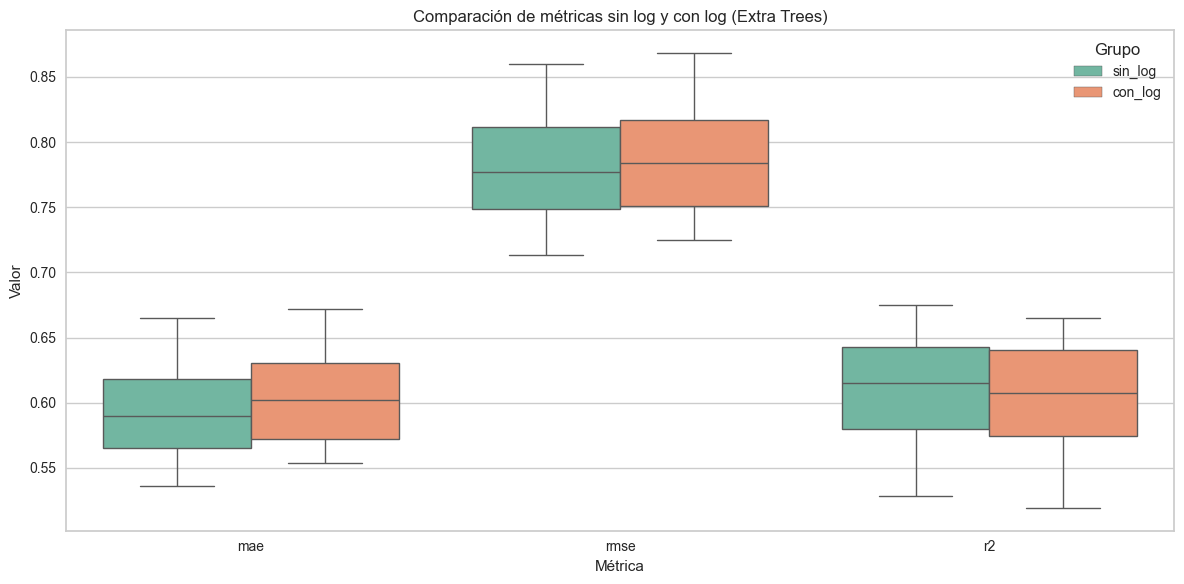

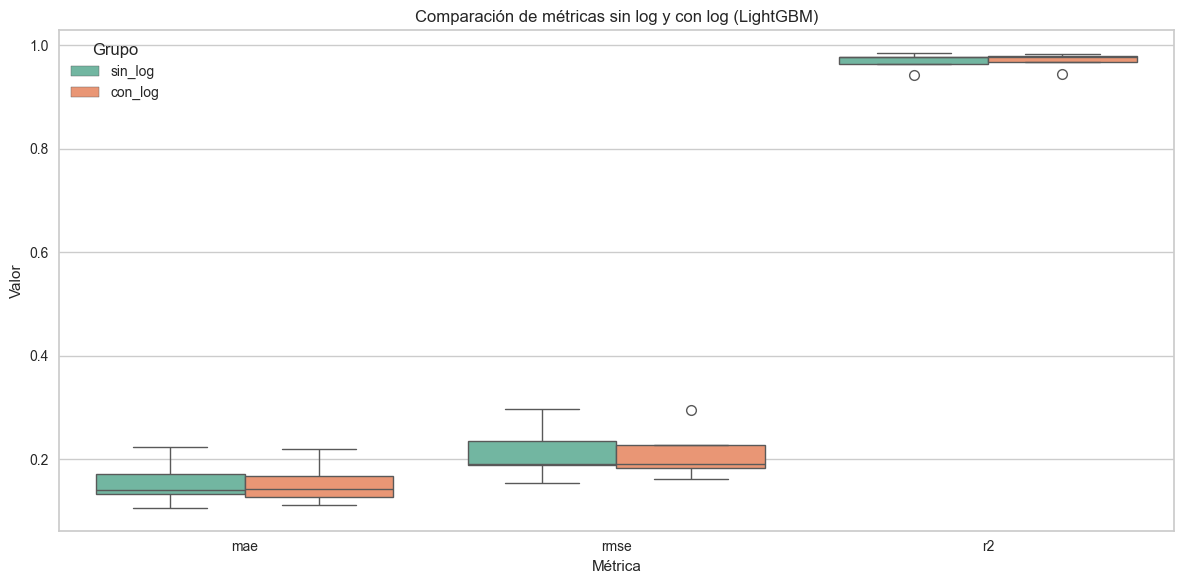

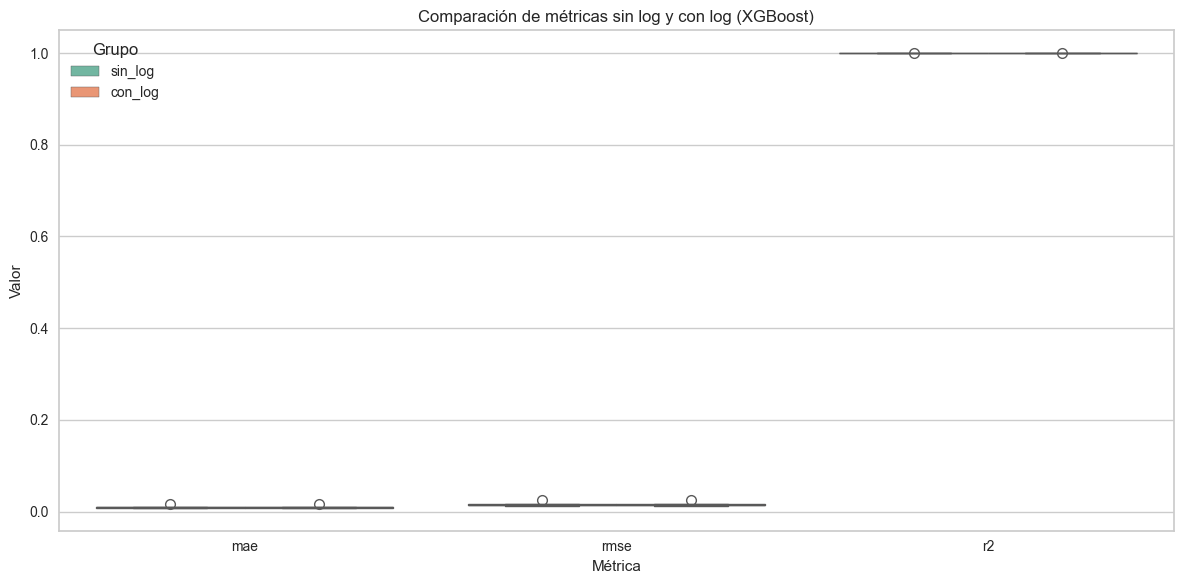

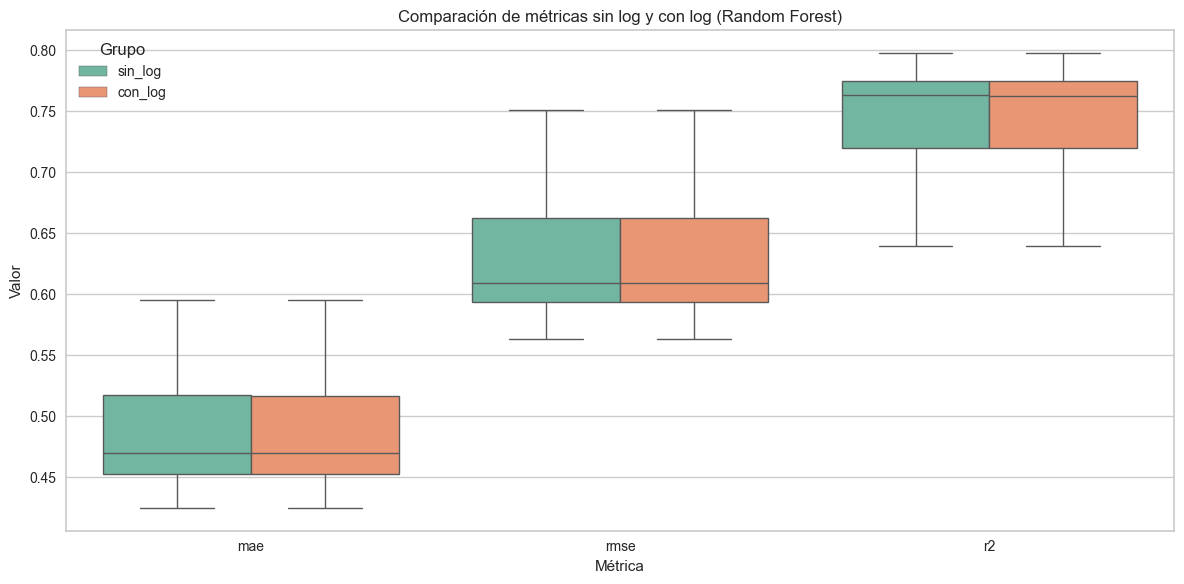

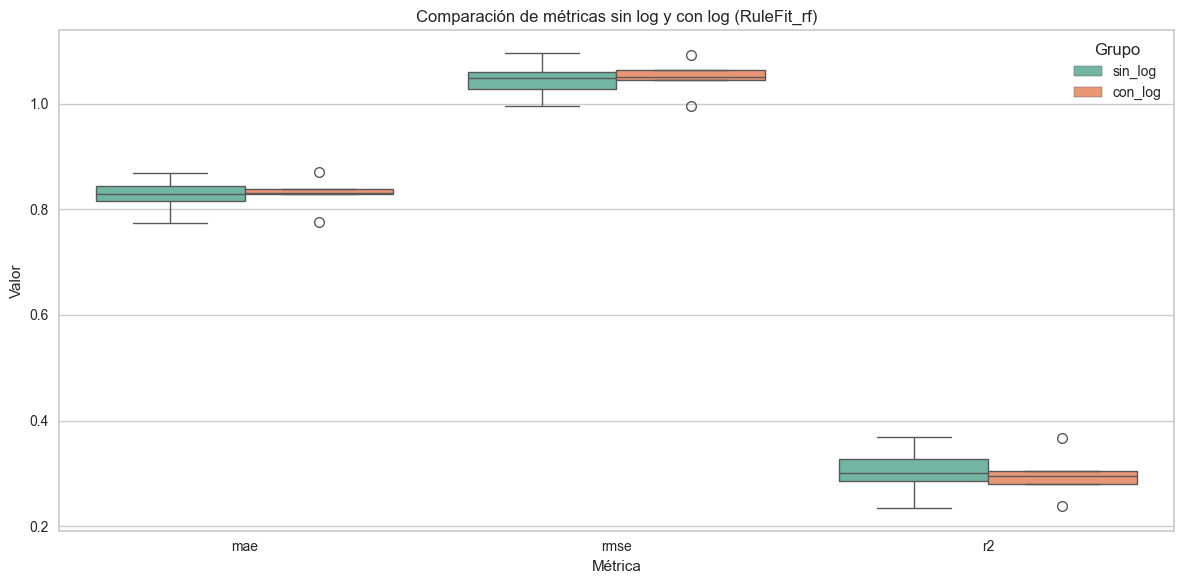

In [22]:
# Renombrar columnas si es necesario
resumen_total_et = resumen_total_et.rename(columns={"Prec.": "Precision"})
resumen_total_xgb = resumen_total_xgb.rename(columns={"Prec.": "Precision"})
resumen_total_lightgbm = resumen_total_lightgbm.rename(columns={"Prec.": "Precision"})
resumen_total_rf = resumen_total_rf.rename(columns={"Prec.": "Precision"})
resumen_total_rf_rf = resumen_total_rf_rf.rename(columns={"Prec.": "Precision"})
# Función para generar gráfico por modelo (regresión)
def graficar_boxplot_metricas(resumen_total, nombre_modelo):
    resumen_largo = resumen_total.melt(
        id_vars=["modelo"],
        value_vars=["mae", "rmse", "r2"],  # métricas de regresión
        var_name="Métrica",
        value_name="Valor"
    )

    resumen_largo["grupo"] = resumen_largo["modelo"].apply(lambda x: "sin_log" if "sin_log" in x else "con_log")

    plt.figure(figsize=(12, 6))
    sns.boxplot(data=resumen_largo, x="Métrica", y="Valor", hue="grupo", palette="Set2")
    plt.title(f"Comparación de métricas sin log y con log ({nombre_modelo})")
    plt.legend(title="Grupo")
    plt.tight_layout()
    plt.show()
    return resumen_largo

# Generar gráficos para cada modelo

resumen_largos = []
resumen_largos.append(graficar_boxplot_metricas(resumen_total_et, "Extra Trees"))
resumen_largos.append(graficar_boxplot_metricas(resumen_total_lightgbm, "LightGBM"))
resumen_largos.append(graficar_boxplot_metricas(resumen_total_xgb, "XGBoost"))
resumen_largos.append(graficar_boxplot_metricas(resumen_total_rf, "Random Forest"))
resumen_largos.append(graficar_boxplot_metricas(resumen_total_rf_rf, "RuleFit_rf"))


In [28]:
for resumen_largo in resumen_largos:
    # Agrupar por grupo y métrica, y calcular la media
    resumen_largo["grupo"] = resumen_largo["modelo"].apply(lambda x: "sin_log" if "sin_log" in x else "con_log")
    resumen_largo["Métrica"] = resumen_largo["Métrica"].str.replace(" ", "_")
    resumen_largo["Valor"] = resumen_largo["Valor"].astype(float)
resumen_medias = resumen_largo.groupby(["grupo", "Métrica"])["Valor"].mean().unstack()
print("Promedio de métricas por grupo:")
print(resumen_medias.round(3))

Promedio de métricas por grupo:
Métrica    mae     r2   rmse
grupo                       
con_log  0.829  0.297  1.049
sin_log  0.827  0.303  1.045
